In [1]:
import os
import torch
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from itertools import product
import json
from collections import defaultdict

from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torchvision import models
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

# from fastai import transforms, model, dataset, conv_learner

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from augmentation import SSDAugmentation, SSD_Val_Augmentation

from Config import *
from SSD_model import get_SSD_model, lr_find
from VOC_data import VOC_dataset
from SSDloss import *

from pathlib import Path
import visdom
import sys
import time
import random
import datetime
from mAP import mAP

In [9]:
config = Config('local')
ssd_model = get_SSD_model(config.batch_size, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model.load_trained_model(config.trained_path)

test_dataset = VOC_dataset(config.voc2007_root, config.voc2012_root, config.voc2007_test_anno, 'test')
# DataLoader = DataLoader(test_dataset)

idx = 20
img, bbox, label, img_id, ignore = test_dataset[idx]

mean_average_precision = mAP(config.voc2007_test_anno)
print(bbox, '\n', label, '\n', img_id, '\n', ignore)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
ssd_model = ssd_model.to(device)
conf, loc = ssd_model(img.unsqueeze(0).to(device))
priors = get_prior_box()

res_score, res_bbox, res_cls = mean_average_precision.nms(conf, loc, priors.to(device), conf_threshold=0.6)
print(res_score, '\n', res_bbox, '\n', res_cls)


D:\1-usc\SSD_PyTorch\SSD_model.py:172: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


[[0.         0.15361446 0.768      0.87349397]] 
 [3] 
 40 
 [0]


D:\1-usc\SSD_PyTorch\mAP.py:185: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf_ = F.softmax(conf[0])


[tensor(0.993, device='cuda:0', grad_fn=<AsStridedBackward>)] 
 [tensor([ -1.640,  61.312, 243.879, 280.910],
       device='cuda:0', grad_fn=<SelectBackward>)] 
 [tensor(3, device='cuda:0')]


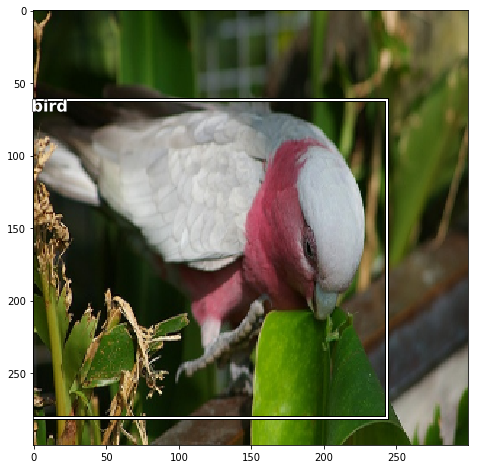

In [12]:
draw_im_with_data(img_, res_bbox, np.array(res_cls), idx_catagory)

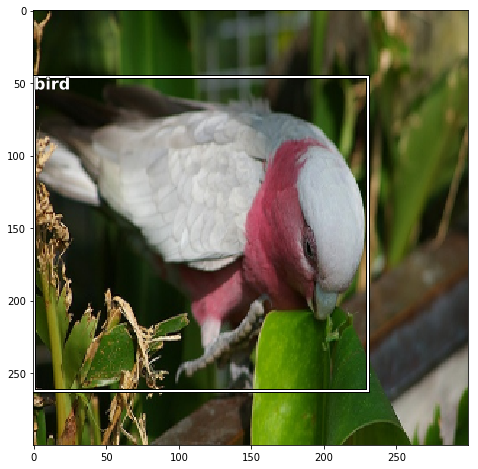

In [11]:
img_ = img.permute(1, 2, 0)
img_ = np.array(img_ + torch.FloatTensor([123, 117, 104]), dtype=np.int)

# plt.imshow(img_)
draw_im_with_data(img_, bbox * 300, label, idx_catagory)

In [ ]:
# refer: https://gluon-cv.mxnet.io/_modules/gluoncv/utils/metrics/voc_detection.html
# refer: https://github.com/amdegroot/ssd.pytorch/blob/master/eval.py
# refer: https://github.com/rafaelpadilla/Object-Detection-Metrics

class mAP():
    def __init__(self, test_json_path):
        self.id_anno = get_id_annotation(test_json_path)
        self.idx_catagory = idx_catagory
        self.catagory_idx = catagory_idx
        
        '''
        self.detection_res.keys() = [1, 20], corresponding to catagory [1, 20]
        self.detection_res[key1] = List[{'score':, 'bbox':, 'label':, 'img_id':} ...]
        len(self.detection_res[key1]) == the number of detected bbox for class key1
        '''
        self.detection_res = {i: [] for i in range(1, 21)}
    
        '''
        self.ground_truths.keys() = all id of images in voc2007 test dataset
        slef.ground_truths[img_id1] = List[Dict{'bbox':, 'label':, 'used':False} ...]
        len(self.ground_truths) = 4952 (number of images in voc2007 test dataset)
        '''
        self.ground_truths = {i: [] for i in self.id_anno.keys()}
    
    def iou(self, bbox1, bbox2):
        wh1 = bbox1[2:] - bbox1[:2]
        wh2 = bbox2[2:] - bbox2[:2]
        area1 = wh1[0] * wh1[1]
        area2 = wh2[0] * wh2[1]
        
        max_xy = np.max(np.stack([bbox1[:2], bbox2[:2]]), axis=0)
        min_xy = np.min(np.stack([bbox1[2:], bbox2[2:]]), axis=0)
        wh  = np.clip(min_xy - max_xy, a_min=0, a_max=float('inf'))
        
        intersect = wh[0] * wh[1]
        iou = intersect / (area1 + area2 - intersect)
        
        return iou
    
    def get_gt_num(self):
        self.gt_num = {_: 0 for _ in range(1, 21)}
        for img_id in self.ground_truths.keys():
            for anno in self.ground_truths[imd_id]:
                self.gt_num[anno['label']] += 1
    
    def calculate_AP(self, recall, precision, metric='07'):
        if metric = '07':
            ap = 0
            for t in np.arange(0, 1.1, 0.1):
                if np.sum(recall > t) == 0:
                    p = 0
                else:
                    p = np.max(precision[recall > t])
                ap += p / 11
        return ap      
            
    
    def calculate_mAP(self, iou_threshold=0.5, metric='07'):
        '''
        metric: 07|12
        07 use 11 interpolation, 12 use all points interpolation
        '''
        self.get_gt_num()
        mAP = dict()
        
        for cls in range(1, 21):
            det = self.detection_res[cls]
            gt =  self.ground_truths
            
            tp, fp = np.array([0 for _ in range(len(det))]), np.array([0 for _ in range(len(det))])
            det = sorted(det, key=lambda k: k['score'], reverse=True)
            
            for det_i, det_item in enumerate(det):
                img_id = det_item['img_id']
                bbox1, label1 = det_item['bbox'], det_item['label']
                
                matched = False
                for i, anno in enumerate(gt[img_id]):
                    if anno['used'] or label1 != anno['label']:
                        continue
                    iou = self.iou(bbox1, anno['bbox'])
                    if iou > iou_threshold:
                        tp[det_i:] += 1 
                        gt[img_id][i]['used'] = True
                if not matched:
                    fp[det_i:] += 1
                    
            recall = tp / self.gt_num[cls]
            precision = tp / (tp + fp)
            ap = self.calculate_AP(recall, precision, metric)
        mAP[cls] = ap
        return mAP
                    
    def add_groundtruth(self, img_id, bboxes, labels, ignores):
        self.ground_truths[img_id] = [{'bbox': bbox, 'label': label, 'used': False, 'ignore': ignore} 
                                      for bbox, label, ignore in zip(np.array(bboxes), 
                                                                   np.array(labels),
                                                                   np.array(ignores))]
        
    def add_predictions(self, img_id, conf_threshold, iou_threshold, top_k, conf, loc, priors):
        nms_score, nms_bbox, nms_cls = self.nms(conf_threshold, iou_threshold, top_k, conf, loc, priors)
        for score, bbox, cls in zip(nms_score, nms_bbox, nms_cls):
            self.detection_res[int(cls)].append({'score': score, 'bbox': bbox, 'label': cls, 'img_id':img_id})
    
    def nms(self, conf, loc, priors, conf_threshold=0.01, iou_threshold=0.45, top_k=200):
        '''
        Description:
        greedy nms

        Arguments:
        conf_threshold: int, default=0.45
        iou_threshold: int, defualt=0.01
        top_k: int, default=5
        conf: 
        loc:
        priors
        '''
        # 1. get the conf_score, conf_cls, bboxes and areaes
        loc_ = decode(loc[0], priors, [0.1, 0.2]) * 300

        conf_ = F.softmax(conf[0])
        conf_score, conf_cls = torch.max(conf_[:, 1:], dim=1)

    #     if use trained model, add this line
        conf_cls += 1

        conf_mask = conf_score > conf_threshold
        conf_score, conf_cls, loc_ = conf_score[conf_mask], conf_cls[conf_mask], loc_[conf_mask]

        conf_score, conf_idx = torch.sort(conf_score, descending=True)
        conf_cls, bboxes = conf_cls[conf_idx], loc_[conf_idx]

        wh = bboxes[:, 2:] - bboxes[:, :2]
        areaes = wh[:, 0] * wh[:, 1]

        # 2. get the result bbox and result class
        res_score, res_bbox, res_cls = [], [], []

        for idx in range(len(conf_score)):
            if conf_score[idx] != 0:
                res_score.append(conf_score[idx])
                res_bbox.append(bboxes[idx])
                res_cls.append(conf_cls[idx])

                for i_head in range(idx + 1, len(conf_score)):
                    if conf_score[i_head] != 0:
                        max_xy = torch.max(bboxes[idx][:2], bboxes[i_head][:2])
                        min_xy = torch.min(bboxes[idx][2:], bboxes[i_head][2:])
                        wh = torch.clamp(min_xy - max_xy, min=0)
                        intersect = wh[0] * wh[1]
                        iou = intersect / (areaes[idx] + areaes[i_head] - intersect)
                        if iou > iou_threshold:
                            conf_score[i_head] = 0

        res_score, res_bbox, res_cls = res_score[:top_k] res_bbox[:top_k], res_cls[:top_k]
        return res_score, res_bbox, res_cls

In [9]:
trn_id_fname, trn_id_annotation, trn_id_single_anno, idx_category, category_idx, imgs, imgs_id, imgs_bbox, imgs_class = get_anno_data()

In [54]:
class draw_scatter():
    def __init__(self, port=8889):
        self.scatter = None
        self.vis = visdom.Visdom(port=port)
    
    def __call__(self, idx_array, loss_array):
        tmp = np.column_stack((np.array(idx_array), np.array(loss_array)))
        if self.scatter == None:
            self.scatter = vis.scatter(tmp)
        else:
            self.scatter = vis.scatter(tmp, win=self.scatter, update='replace')
            
class my_timer(object):
    def __init__(self):
        self.start_time = time.time()
        
    def __call__(self):
        return str(datetime.timedelta(seconds=int(time.time() - self.start_time)))

In [ ]:
vis.line()

In [55]:
scatter = draw_scatter()

In [58]:
scatter(idx_array * 2, loss_array + 10)

In [9]:
a = vis.scatter([[0, 0]], win=win_text, update='append')

In [11]:
for i in range(10):
    vis.scatter([[i, i]], win=win_text, update='append')

In [14]:
vis.scatter([[1,3], [2, 4]], win=a, update='append')

'window_3711252ca8b0a2'

In [36]:
t1 = datetime.datetime.now()

In [41]:
t1

datetime.datetime(2019, 2, 12, 11, 11, 20, 760303)

In [68]:
datetime.datetime.now() - t1

datetime.timedelta(0, 88, 588816)

In [69]:
t2 = time.time()
t2

1549998774.457312

In [101]:
time.time() - t2

65.66897130012512

In [117]:
time.time() - t2

410.6413962841034

In [120]:
str(datetime.timedelta(seconds=int(time.time() - t2)))

'0:06:59'

In [24]:
loss_plot = None
vis = visdom.Visdom(port=8889)

def random_generator(k):
    for i in range(k):
        time.sleep(0.5)
        yield [i, i + random.uniform(i - 2, i + 2)]
        
for x, y in random_generator(20):
    if loss_plot:
        vis.line(np.array([y]), np.array([x]), win=loss_plot, update='append')
    else:
        loss_plot = vis.line(np.array([y]), np.array([x]))

In [11]:
res = [[0, 0]]
vis = visdom.Visdom(port=8889)
vis.scatter(res)
for i in range(10):
    res.append((i, i))
    time.sleep(10)
#     vis.scatter(res)

In [4]:
import visdom

vis = visdom.Visdom(port=8889)
vis.scatter([[None, None]])

TypeError: must be real number, not NoneType

In [2]:
def detection_collate_fn(batch):
    imgs, bboxes, labels = [], [], []
    for i, b, l in batch:
        imgs.append(i); bboxes.append(b); labels.append(l)
    return torch.stack(imgs), bboxes, labels

In [3]:
trn_id_fname, trn_id_annotation, trn_id_single_anno, idx_category, category_idx, imgs, imgs_id, imgs_bbox, imgs_class = get_anno_data()

In [7]:
conf_threshold = 0.1
iou_threshold = 0.45
top_k = 5

config = Config('local')
ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model.load_trained_model(config.trained_path)
test_dataset = VOC_dataset(config.voc2007_root, config.voc2012_root, config.voc2007_test_anno, 'test')

idx = 19
img, bbox, label = test_dataset[idx]

conf, loc = ssd_model(img.unsqueeze(0))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
ssd_model = ssd_model.to(device)

priors = get_prior_box()
res_bbox, res_cls = nms(conf_threshold, iou_threshold, top_k, conf, loc, priors)
print(res_bbox)

D:\1-usc\SSD_PyTorch\SSD_model.py:172: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)
D:\1-usc\SSD_PyTorch\SSDloss.py:268: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf_ = F.softmax(conf[0])


[tensor([ 92.270, 131.833, 166.532, 190.522], grad_fn=<SelectBackward>), tensor([114.593,  86.905, 149.618, 183.229], grad_fn=<SelectBackward>)] [tensor(2), tensor(15)]


In [8]:
print(res_bbox)
print(res_cls)

[tensor([ 92.270, 131.833, 166.532, 190.522], grad_fn=<SelectBackward>), tensor([114.593,  86.905, 149.618, 183.229], grad_fn=<SelectBackward>)]
[tensor(2), tensor(15)]


D:\1-usc\SSD_PyTorch\SSD_model.py:172: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


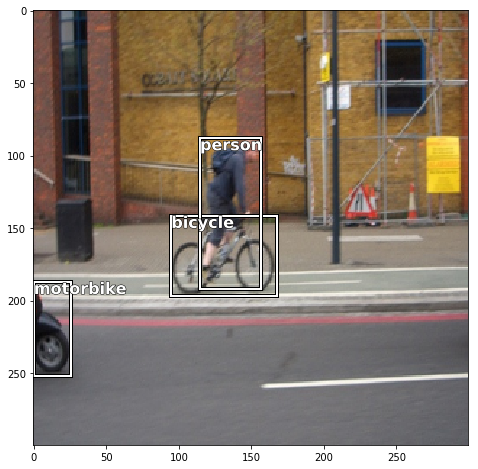

In [382]:
conf_threshold = 0.1
iou_threshold = 0.45

config = Config('local')
ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model.load_trained_model(config.trained_path)
test_dataset = VOC_dataset(config.voc2007_root, config.voc2012_root, config.voc2007_test_anno, 'test')

idx = 19
img, bbox, label = test_dataset[idx]

img_ = img.permute(1, 2, 0)
img_ = np.array(img_ + torch.FloatTensor([123, 117, 104]), dtype=np.int)

# plt.imshow(img_)
draw_im_with_data(img_, bbox * 300, label, idx_category)

In [383]:
conf, loc = ssd_model(img.unsqueeze(0))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
ssd_model = ssd_model.to(device)

In [384]:
loc_ = decode(loc[0], priors, [0.1, 0.2]) * 300

conf_ = F.softmax(conf[0])
conf_score, conf_cls = torch.max(conf_[:, 1:], dim=1)
conf_cls += 1

conf_mask = conf_score > conf_threshold
conf_score, conf_cls, loc_ = conf_score[conf_mask], conf_cls[conf_mask], loc_[conf_mask]

conf_score, conf_idx = torch.sort(conf_score, descending=True)
conf_cls, bboxes = conf_cls[conf_idx], loc_[conf_idx]

wh = bboxes[:, 2:] - bboxes[:, :2]
areaes = wh[:, 0] * wh[:, 1]

D:\py3\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [385]:
res_bbox = []
res_cls = []

for idx in range(len(conf_score)):
    if conf_score[idx] != 0:
        res_bbox.append(bboxes[idx])
        res_cls.append(conf_cls[idx])
        
        for i_head in range(idx + 1, len(conf_score)):
            if conf_score[i_head] != 0:
                max_xy = torch.max(bboxes[idx][:2], bboxes[i_head][:2])
                min_xy = torch.min(bboxes[idx][2:], bboxes[i_head][2:])
                wh = torch.clamp(min_xy - max_xy, min=0)
                intersect = wh[0] * wh[1]
                iou = intersect / (areaes[idx] + areaes[i_head] - intersect)
                if iou > iou_threshold:
                    conf_score[i_head] = 0
            else:
                continue
    else:
        continue

res_bbox = res_bbox[:5]
res_cls = res_cls[:5]

In [388]:
res_bbox

[tensor([ 92.270, 131.833, 166.532, 190.522], grad_fn=<SelectBackward>),
 tensor([114.593,  86.905, 149.618, 183.229], grad_fn=<SelectBackward>)]

In [389]:
res_cls

[tensor(2), tensor(15)]

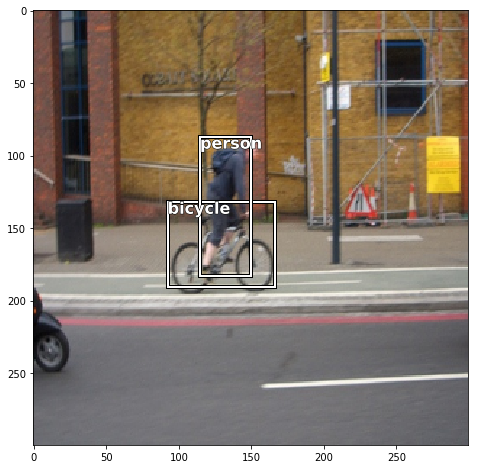

In [386]:
img_ = img.permute(1, 2, 0)
img_ = np.array(img_ + torch.FloatTensor([123, 117, 104]), dtype=np.int)

draw_im_with_data(img_, np.array(res_bbox), np.array(res_cls), idx_category)

In [387]:
priors = get_prior_box()
iou = get_iou(bbox, priors)

pos_mask, cls_target, bbox_target = get_target(iou, priors, img, bbox, label)
neg_mask = 1 - pos_mask

d_bbox = decode(bbox_target, priors, [0.1, 0.2])

loc_p = loc[(pos_mask).unsqueeze(0)].view(-1, 4)
loc_t = bbox_target[pos_mask].view(-1, 4)
loss_l = F.smooth_l1_loss(loc_p, loc_t, size_average=False)

loss_loc, loss_cls = loss(conf[0], loc[0], pos_mask, cls_target, bbox_target)
print(torch.sum(loss_cls), torch.sum(loss_loc))

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(1.977, grad_fn=<SumBackward0>) tensor(0.899, grad_fn=<SumBackward0>)


In [18]:
c = nn.SmoothL1Loss(reduce=False)
l = loc[0]
l_ = c(l[pos_mask], bbox_target[pos_mask])

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [23]:
loss_conf = F.cross_entropy(conf[0], cls_target.long(), reduction='none')

In [24]:
torch.sum(loss_conf)

tensor(54.362, grad_fn=<SumBackward0>)

In [28]:
loss_c_pos = torch.sum(loss_conf[pos_mask])

In [29]:
loss_c_pos

tensor(17.477, grad_fn=<SumBackward0>)

In [30]:
num_pos = torch.sum(pos_mask)
ratio = 3

In [125]:
_, neg_idx = torch.sort(loss_conf[neg_mask], descending=True)

In [126]:
loss_c_neg = loss_conf[neg_mask][neg_idx[:num_pos * ratio]]

In [128]:
torch.sum(loss_c_neg)

tensor(8.564, grad_fn=<SumBackward0>)

In [129]:
loss_c_pos + torch.sum(loss_c_neg)

tensor(26.041, grad_fn=<ThAddBackward>)

In [110]:
x = torch.randn(4, 4)
y = torch.randn(4, 1)
w = nn.Parameter(torch.randn(4, 1))
b = nn.Parameter(torch.randn(1, 1))

pred = torch.matmul(x, w) + b
conf_loss = F.smooth_l1_loss(pred, y, reduction='none')

conf_loss

tensor([[3.997],
        [0.452],
        [1.382],
        [3.567]], grad_fn=<SmoothL1LossBackward>)

In [115]:
_, idx = torch.sort(conf_loss, dim=0, descending=True)
total_conf_loss = torch.sum(conf_loss[idx[:2]]) / 2
total_conf_loss

l1, l2, l3, l4 = conf_loss

l = (l1 + l4) / 2

In [116]:
total_conf_loss

tensor(3.782, grad_fn=<DivBackward0>)

In [117]:
l

tensor([3.782], grad_fn=<DivBackward0>)

In [118]:
l.backward(retain_graph=True)

In [119]:
b.grad

tensor([[1.]])

In [120]:
b.grad = torch.zeros(1, 1)

In [121]:
b.grad

tensor([[0.]])

In [122]:
total_conf_loss.backward(retain_graph=True)

In [123]:
b.grad

tensor([[1.]])

In [6]:
prior_box = get_prior_box()
loss_array = []

for i, batch in enumerate(trn_dataloader):

    imgs, bboxes, labels = batch
    imgs = imgs.to(device)
    cls_preds, loc_preds = ssd_model(imgs)

#     model.zero_grad()

    total_loss = 0
    total_loc_loss, total_cls_loss = 0, 0

    for idx in range(imgs.shape[0]):

        img, bbox, label = imgs[idx], bboxes[idx], labels[idx]
        cls_pred, loc_pred = cls_preds[idx], loc_preds[idx]
        iou = get_iou(bbox, prior_box)

        pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)
        pos_mask, cls_target, bbox_target = pos_mask.to(device), cls_target.to(device), bbox_target.to(device)

        loss_loc, loss_cls = loss(cls_pred, loc_pred, pos_mask, cls_target, bbox_target)
        total_loc_loss += loss_loc; total_cls_loss += loss_cls

        total_loss += (loss_cls + loss_loc)

    total_loss /= float(imgs.shape[0])
    total_cls_loss /= float(imgs.shape[0])
    total_loc_loss /= float(imgs.shape[0])

#     total_loss.backward()

#     optimizer.step()
    cls_loss = round(float(total_cls_loss), 3)
    loc_loss = round(float(total_loc_loss), 3)
    t_loss = round(float(total_loss), 3)

    print(i, 'cls_loss: {}, loc_loss: {}, loss: {}'.format(cls_loss, loc_loss, t_loss))
    loss_array.append(t_loss)

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0 cls_loss: 9.103, loc_loss: 4.608, loss: 13.711
1 cls_loss: 9.528, loc_loss: 3.767, loss: 13.295
2 cls_loss: 9.228, loc_loss: 3.088, loss: 12.316
3 cls_loss: 9.208, loc_loss: 7.935, loss: 17.142
4 cls_loss: 8.811, loc_loss: 4.791, loss: 13.602
5 cls_loss: 8.592, loc_loss: 4.327, loss: 12.92
6 cls_loss: 8.326, loc_loss: 3.546, loss: 11.872
7 cls_loss: 9.201, loc_loss: 9.054, loss: 18.254
8 cls_loss: 8.948, loc_loss: 10.308, loss: 19.256
9 cls_loss: 10.047, loc_loss: 5.539, loss: 15.586
10 cls_loss: 10.427, loc_loss: 4.072, loss: 14.499
11 cls_loss: 6.396, loc_loss: 5.328, loss: 11.724
12 cls_loss: 9.155, loc_loss: 4.246, loss: 13.401
13 cls_loss: 6.205, loc_loss: 7.109, loss: 13.314
14 cls_loss: 9.29, loc_loss: 5.714, loss: 15.004
15 cls_loss: 7.516, loc_loss: 4.717, loss: 12.234
16 cls_loss: 8.497, loc_loss: 6.005, loss: 14.503
17 cls_loss: 8.481, loc_loss: 6.423, loss: 14.904
18 cls_loss: 10.271, loc_loss: 4.646, loss: 14.917
19 cls_loss: 9.056, loc_loss: 6.009, loss: 15.066
20 cls_l

323 cls_loss: 7.187, loc_loss: 5.416, loss: 12.602
324 cls_loss: 9.172, loc_loss: 5.714, loss: 14.886
325 cls_loss: 8.605, loc_loss: 7.542, loss: 16.147
326 cls_loss: 10.065, loc_loss: 6.727, loss: 16.792
327 cls_loss: 8.126, loc_loss: 5.625, loss: 13.752
328 cls_loss: 8.215, loc_loss: 7.198, loss: 15.412
329 cls_loss: 6.03, loc_loss: 4.316, loss: 10.346
330 cls_loss: 10.816, loc_loss: 7.623, loss: 18.44
331 cls_loss: 10.078, loc_loss: 6.571, loss: 16.649
332 cls_loss: 10.149, loc_loss: 4.471, loss: 14.62
333 cls_loss: 9.258, loc_loss: 9.792, loss: 19.051
334 cls_loss: 11.693, loc_loss: 3.753, loss: 15.446
335 cls_loss: 5.477, loc_loss: 12.576, loss: 18.053
336 cls_loss: 7.871, loc_loss: 4.874, loss: 12.745
337 cls_loss: 8.877, loc_loss: 4.493, loss: 13.37
338 cls_loss: 7.909, loc_loss: 5.69, loss: 13.599
339 cls_loss: 8.332, loc_loss: 7.047, loss: 15.379
340 cls_loss: 8.8, loc_loss: 8.016, loss: 16.816
341 cls_loss: 9.133, loc_loss: 7.441, loss: 16.574
342 cls_loss: 9.842, loc_loss: 3

KeyboardInterrupt: 

In [13]:
cls_target[pos_mask]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3], device='cuda:0', dtype=torch.int32)

In [20]:
(cls_pred[pos_mask].shape)

torch.Size([78, 21])

In [2]:
import torch
from torch import nn

In [42]:
l = nn.Conv2d(1, 1, kernel_size=(3, 3), stride=1, padding=0)
l.weight = nn.Parameter(torch.ones(1, 1, 3, 3).float())
x = torch.zeros(35)
for i in range(25):
    x[i] = i
x = x.reshape(1, 1, 5, 7)
x.shape

torch.Size([1, 1, 5, 7])

In [43]:
l.weight

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)

In [44]:
l.bias = nn.Parameter(torch.FloatTensor([0]))

In [45]:
x

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
          [ 7.,  8.,  9., 10., 11., 12., 13.],
          [14., 15., 16., 17., 18., 19., 20.],
          [21., 22., 23., 24.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [64]:
torch.reshape(l(x), (-1, 1))

tensor([[ 72.],
        [ 81.],
        [ 90.],
        [ 99.],
        [108.],
        [135.],
        [144.],
        [128.],
        [111.],
        [ 93.],
        [111.],
        [117.],
        [ 98.],
        [ 78.],
        [ 57.]], grad_fn=<AsStridedBackward>)

In [65]:
x.shape

torch.Size([1, 1, 5, 7])

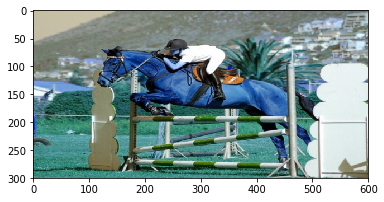

In [47]:
img1_path, img2_path = 'C:\\datasets\\pascal\\JPEGImages\\000012.jpg', 'C:\\datasets\\pascal\\JPEGImages\\000017.jpg'
img1, img2 = cv2.imread(img1_path), cv2.imread(img2_path)
img1, img2 = cv2.resize(img1, (600, 300)), cv2.resize(img2, (600, 300))

plt.imshow(img2)

In [48]:
img2.shape

(300, 600, 3)

In [51]:
x.reshape(35)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.])